In [1]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
import numpy as np
from typing import List
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence, pad_packed_sequence, pad_sequence, pack_sequence
from sklearn.metrics import accuracy_score



In [3]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# constants and global variables


# Data loading

In [6]:

def load_X_data(file_name):
  tweets = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        tweets.append(line.rstrip().split())
  
  #Tweets of varying size hence the dtype
  return np.array(tweets, dtype=object)


def load_y_data(file_name):
  labels = []
  with open(DATA_PATH.format(file_name), 'r', encoding='utf-8') as f:
      for line in f:
        labels.append(int(line.rstrip()))
  
  return np.array(labels)



In [7]:
data_size = 500

X_data = load_X_data('X_train_processed_full.txt')
y_data = load_y_data("y_train_full.txt")
print(f'X_data shape: {X_data.shape}, y_data shape: {y_data.shape}')



X_data shape: (2500000,), y_data shape: (2500000,)


In [8]:
from gensim.models import Word2Vec
import multiprocessing

# Count the number of cores in the computer
cores = multiprocessing.cpu_count()
print(cores)

w2v_model = Word2Vec.load(MODEL_PATH.format("word2vec_full.model"))



4


# Embedding

In [9]:
#Map each word in each sentence to its embedding. If it is not skip it, a sentence is a matrix of embeddings
#Dataset is sequence of such matrix (variable widths).
def map_to_embedding(X_data: np.array, w2v: Word2Vec):
    res = []
    #Iterate over all tweets of the dataset
    for sentence in X_data:
        sentence_embed = [] 
        for word in sentence:
            #Check if in the vocab, if not do nothing
            if word in w2v_model.wv.vocab:
                #Add the word to the sentence embedding matrix
                sentence_embed.append([w2v.wv[word]])
        res.append(np.array(sentence_embed).reshape(-1, w2v.wv.vector_size))
    return np.array(res, dtype=object)


def filter_out_invalid(X_embedded, y_data):
    lengths = np.array([len(stc) for stc in X_embedded])
    mask = np.ma.masked_where(len(X_embedded) > 0, lengths)
    return X_embedded[lengths > 0], y_data[lengths > 0]


X_data_embedded = map_to_embedding(X_data, w2v_model)


In [10]:
#We drop sentences where all words are out of of vocabulary
X_embedded_valid, y_valid = filter_out_invalid(X_data_embedded, y_data)
print(X_embedded_valid.shape)
print(y_valid.shape)


(2483804,)
(2483804,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_embedded_valid, y_valid, test_size=0.2, random_state=42)
print(y_test.shape)
print(X_test.shape)

(496761,)
(496761,)


# Model

In [12]:
from torch.functional import F

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, **kwargs):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first = True)

        
        #Bidirectional, concatenate first and last hidden state. Classify based on that
        # Implementation already creates hidden state * 2 hence the * 4 factor                        
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32,2)

        )

        self.mlp.apply(init_weights)


        

    def forward(self, x: np.array):

        #We pass a single sequence to the method, no batching.
        if len(x.shape) == 2:
            print('In first instance')

            
            # Returns hidden states of the last hidden layer at different time
            # steps. The shape of `outputs` is (no. of time steps, batch size,
            # 2 * no. of hidden units)
            outputs, _ = self.lstm(torch.tensor(x))
            # Concatenate the hidden states of the initial time step and final
            # time step to use as the input of the fully connected layer. Its
            # shape is (batch size, 4 * no. of hidden units)

            x = torch.cat((outputs[0], outputs[-1]), dim=0)

 

        else:
            #We are passed a list of Ndarrays which themselves have varying length.
            x_tensored = [torch.tensor(y) for y in x]
            x_padded = pad_sequence(x_tensored, batch_first=True)
            lengths = torch.as_tensor([v.size(0) for v in x_tensored])

            x_packed = pack_padded_sequence(x_padded, lengths, batch_first=True, enforce_sorted = False).to(device)


            #By not providing h0 and c0 they default to 0 in all necessary places (1 per layer per direction of size hidden_size)
            outputs, _ = self.lstm(x_packed)
            outputs, input_sizes = pad_packed_sequence(outputs, batch_first= True)


            #Indexing is (Batch, Sequence, Features). For each batch we access the first element of the sequence.
            outputs_0 = outputs[:, 0, :]

            #Here for each batch we access the last element. Note no semi column because we have differing last elements indices.
            #If we passed array of last indices then it would fetch multiple feature vectors per batch
            #I.e elements corresponding to last state of each last index in the batch
            outputs_end = torch.stack([outputs[batch_idx, seq_length - 1, :] for batch_idx, seq_length in enumerate(input_sizes)], dim = 0)

            x = torch.cat((outputs_0, outputs_end), dim = -1)

        x = self.mlp(x)
        return x








In [13]:
#Initializing the network
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

hidden_features = 300
number_layers = 1
lr = 1
criterion = nn.CrossEntropyLoss()

model = BiRNN(w2v_model.wv.vector_size, hidden_features, number_layers, 2).to(device)

optimizer_adam = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizer_SGD = SGD(model.parameters(), lr=0.01, momentum=0.9)

optimizer = optimizer_adam
lr_scheduler = ReduceLROnPlateau(optimizer)



In [14]:

all_collected_loss = []
batch_size = 64
number_epochs = 10


training_losses = []
validation_accuracies = []
validation_losses = []
training_accuracies = []
validation_accuracy = None
device
validation_batch_size = 50
all_indices = [i for i in range(len(X_test))]
validation__batch_indices = np.array([all_indices[i: i + validation_batch_size] for i in range(0, len(X_test), validation_batch_size)], dtype=object)


for epoch in range(number_epochs):  # loop over the dataset multiple times

    running_loss = 0
    epoch_running_loss = 0.0
    curr_training_losses = []
    curr_training_accuracies = []

    #For each epoch we shuffle all the indices
    shuffle_idx = np.random.permutation(len(X_train))
    
    #We then create batches among the shuffled indices
    batch_indices = [shuffle_idx[i: i + batch_size] for i in range(0, len(X_train), batch_size)]

    for batch_number, batch in enumerate(batch_indices):
        
        batch_samples_indices = shuffle_idx[batch]

        x, y = X_train[batch_samples_indices], torch.tensor(y_train[batch_samples_indices], dtype=torch.long, device=device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        accuracy = accuracy_score(y.cpu(), np.argmax(outputs.cpu().detach().numpy(), axis=1))

        curr_training_accuracies.append(accuracy)
        curr_training_losses.append(loss.item())
        

        print(f'Epoch {epoch}, batch {batch_number}/{len(batch_indices)}, batch accuracy: {accuracy} loss: {loss}, current val accuracy: {validation_accuracy}')


    lr_scheduler.step(running_loss)
   

    #VALIDATION
    #We batch the calculations on the validation set because my computer is weak.
    #It cannot create predictions for the whole validation set at once
    validation_X_batches = []
    validation_y_batches = []

    #Generating the batches points
    for idx_set in validation__batch_indices:
        validation_X_batches.append(X_test[idx_set])
        validation_y_batches.append(y_test[idx_set])

    #Computing outpus for validation in batched manners 
    outputs = [model(batch).cpu().detach().numpy() for batch in validation_X_batches]

    
    #Computing outputs in b
    y_validation_outs = [np.argmax(batch, axis=1) for batch in outputs]


    #TODO: Add size of batch to weigh the accuracy when doing the mean.
    batch_accuracies = []
    batch_losses = []
    for i, preds_batch in enumerate(y_validation_outs):

        batch_accuracies.append(accuracy_score(validation_y_batches[i], preds_batch))

        #Loss is computed with outputs not with the prediction
        batch_losses.append(criterion(torch.tensor(outputs[i]), torch.tensor(validation_y_batches[i]).to(dtype=torch.long)))


    validation_accuracy = np.array(batch_accuracies).mean()
    validation_loss = np.array(batch_losses).mean()

    #Note since last batch is not same sized we have slight mistake on the weighting
    training_losses.append(np.array(curr_training_losses).mean())
    training_accuracies.append(np.array(curr_training_accuracies).mean())
    validation_accuracies.append(validation_accuracy)
    validation_losses.append(validation_loss)


torch.save(model, MODEL_PATH.format("RNN.model"))





print('Finished Training')


Streaming output truncated to the last 5000 lines.
Epoch 9, batch 26049/31048, batch accuracy: 0.828125 loss: 0.3571449816226959, current val accuracy: 0.8165356463182551
Epoch 9, batch 26050/31048, batch accuracy: 0.828125 loss: 0.34724679589271545, current val accuracy: 0.8165356463182551
Epoch 9, batch 26051/31048, batch accuracy: 0.890625 loss: 0.22673149406909943, current val accuracy: 0.8165356463182551
Epoch 9, batch 26052/31048, batch accuracy: 0.890625 loss: 0.21344365179538727, current val accuracy: 0.8165356463182551
Epoch 9, batch 26053/31048, batch accuracy: 0.90625 loss: 0.2537328898906708, current val accuracy: 0.8165356463182551
Epoch 9, batch 26054/31048, batch accuracy: 0.765625 loss: 0.4584670960903168, current val accuracy: 0.8165356463182551
Epoch 9, batch 26055/31048, batch accuracy: 0.90625 loss: 0.23025880753993988, current val accuracy: 0.8165356463182551
Epoch 9, batch 26056/31048, batch accuracy: 0.890625 loss: 0.22802646458148956, current val accuracy: 0.816

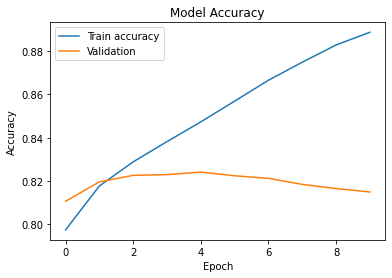

In [16]:
  plt.plot(training_accuracies)
  plt.plot(validation_accuracies)
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train accuracy', 'Validation'], loc='upper left')
  plt.show()


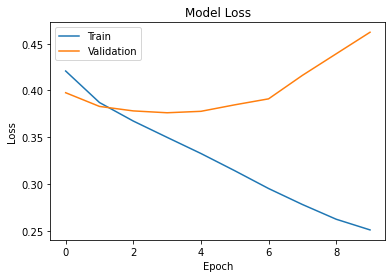

In [17]:
  plt.plot(training_losses)
  plt.plot(validation_losses)
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [18]:
validation_accuracies

[0.810642841458059,
 0.8196223100570927,
 0.822631569316352,
 0.8229647928560972,
 0.8241060972039234,
 0.8224354047723613,
 0.8212558556580296,
 0.8184639877031182,
 0.8165356463182551,
 0.8149553506075246]